<a href="https://colab.research.google.com/github/lokkuuuu/Machine-Learning-for-medical-image-classification/blob/main/BreastHis_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Histology Image Classfication

## Mounting to Google Drive

In [ ]:
#Mount to google drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
#Change to working directory
%cd drive/MyDrive/BreakHis/

/content/drive/MyDrive/BreakHis


## Import Necessary Libraries

In [ ]:
#install required libraries
!pip install scikit-plot
#Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import shutil
import cv2
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall
import tensorflow as tf
#library for CNN
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Lambda, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint
from tensorflow.keras.metrics import Accuracy,binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

## Resnet


### Function

In [ ]:
IMAGE_SIZE = (224, 340)
CROP_SIZE = (224, 224)
BATCH_SIZE = 128
def dataset(ds_path, *,
            train,
            preprocess_fn=None,
            image_size=IMAGE_SIZE,
            crop_size=CROP_SIZE,
            batch_size=BATCH_SIZE):
    """
    Dataset prepocess function by Saini, Manisha and Susan, Seba
    https://github.com/SainiManisha/VGGIN-Net
    """
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)

    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)

    @tf.function
    def augment(images, labels):
        augment_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,[image],tf.float32),images)
        augment_images = tf.ensure_shape(augment_images, images.shape)
        return augment_images, labels

    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        crop_images = crop_layer(images, training = train)
        return crop_images, labels

    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    if preprocess_fn:
        ds = ds.map(preprocess_fn)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [ ]:
def evaluate_report(data,model):
  y_true = []
  y_pred = []
  for images, labels in data:
    preds = model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)
  y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
  y_probas = y_pred
  y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
  print('Accuracy: ', accuracy_score(y_true, y_pred))
  print(classification_report(y_true, y_pred))
  plot_confusion_matrix(y_true, y_pred)
  plot_confusion_matrix(y_true, y_pred, normalize=True)
  plot_roc(y_true, y_probas)
  plot_precision_recall(y_true,y_probas)

In [ ]:
def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [ ]:
def plot_result(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  #Getting the losses
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  #No of epochs it trained
  epochs_range = history.epoch
  #Plotting Training and Validation accuracy
  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.style.use('ggplot')
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy', linestyle = "dashed")
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  #Plotting Training and Validation Loss
  plt.subplot(1, 2, 2)
  plt.style.use('ggplot')
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss', linestyle = "dashed")
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

### MIB

In [ ]:
def resnet_builder():
    base_model = ResNet50(include_top=False, input_shape=(224, 224, 3))

    for i in base_model.layers:
      i.trainable = False

    preprocess_layer = Lambda(preprocess_input, name = 'preprocess')
    image = Input((224, 224, 3))
    preprocess_tensor = preprocess_layer(image)

    pre_out = base_model(preprocess_tensor)
    pre_model = Model(inputs = image , outputs = pre_out)

    def dimension_reductions_inception_module(input_layer):
        # 1x1 conv
        conv1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_layer)
        # 1x1 & 3x3 conv
        conv1_3 = Conv2D(64, (1,1), padding='same', activation='relu')(input_layer)
        conv3_3 = Conv2D(128, (3,3), padding='same', activation='relu')(conv1_3)
        # 1x1 & 5x5 conv
        conv1_5 = Conv2D(64, (1,1), padding='same', activation='relu')(input_layer)
        conv5_5 = Conv2D(32, (5,5), padding='same', activation='relu')(conv1_5)
        # 3x3 max pooling & 1x1
        pool_1 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_layer)
        conv1_p = Conv2D(64, (1,1), padding='same', activation='relu')(pool_1)
        # concatenate filters
        output_layer = Concatenate()([conv1, conv3_3, conv5_5, conv1_p])

        return output_layer

    pool_pre_model = MaxPooling2D((3,3), padding='same')(pre_model.output)
    fin_out = dimension_reductions_inception_module(pool_pre_model)
    b_norm = BatchNormalization()(fin_out)
    flat = Flatten()(b_norm)
    drop = Dropout(0.4)(flat)
    dense = Dense(2, activation='softmax')(drop)

    final_model = Model(inputs = pre_model.input, outputs = dense)

    return final_model

In [ ]:
train_generation = dataset("./training_image/",train = True)
val_generation = dataset("./validating_image/",train = False)
test_gen = dataset("./testing_image/",train = False)

Found 8758 files belonging to 2 classes.
Found 712 files belonging to 2 classes.
Found 791 files belonging to 2 classes.


In [ ]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=1000,
  decay_rate=1,
  staircase=False)

In [ ]:
#Defining the base model
model = resnet_builder()
model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 preprocess (Lambda)            (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['preprocess[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2

In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Model is fitted using train and validation generator for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
69/69 [==============================] - ETA: 0s - loss: 0.4533 - accuracy: 0.8220 

69/69 [==============================] - 2169s 26s/step - loss: 0.4533 - accuracy: 0.8220 - val_loss: 0.3810 - val_accuracy: 0.8764
Epoch 2/50
69/69 [==============================] - ETA: 0s - loss: 0.2877 - accuracy: 0.8943

69/69 [==============================] - 291s 4s/step - loss: 0.2877 - accuracy: 0.8943 - val_loss: 0.3377 - val_accuracy: 0.8890
Epoch 3/50
69/69 [==============================] - ETA: 0s - loss: 0.2397 - accuracy: 0.9098

69/69 [==============================] - 294s 4s/step - loss: 0.2397 - accuracy: 0.9098 - val_loss: 0.2444 - val_accuracy: 0.9171
Epoch 4/50
69/69 [==============================] - ETA: 0s - loss: 0.2035 - accuracy: 0.9211

69/69 [==============================] - 300s 4s/step - loss: 0.2035 - accuracy: 0.9211 - val_loss: 0.1866 - val_accuracy: 0.9354
Epoch 5/50
69/69 [==============================] - 269s 4s/step - loss: 0.1735 - accuracy: 0.9363 - val_loss: 0.2180 - val_accuracy: 0.9326
Epoch 6/50
69/69 [==============================] - ETA: 0s - loss: 0.1654 - accuracy: 0.9353

69/69 [==============================] - 282s 4s/step - loss: 0.1654 - accuracy: 0.9353 - val_loss: 0.1643 - val_accuracy: 0.9593
Epoch 7/50
69/69 [==============================] - 261s 4s/step - loss: 0.1496 - accuracy: 0.9447 - val_loss: 0.1868 - val_accuracy: 0.9382
Epoch 8/50
69/69 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.9547

69/69 [==============================] - 287s 4s/step - loss: 0.1327 - accuracy: 0.9547 - val_loss: 0.1617 - val_accuracy: 0.9480
Epoch 9/50
69/69 [==============================] - ETA: 0s - loss: 0.1209 - accuracy: 0.9586

69/69 [==============================] - 293s 4s/step - loss: 0.1209 - accuracy: 0.9586 - val_loss: 0.1284 - val_accuracy: 0.9551
Epoch 10/50
69/69 [==============================] - 268s 4s/step - loss: 0.1185 - accuracy: 0.9572 - val_loss: 0.1496 - val_accuracy: 0.9508
Epoch 11/50
69/69 [==============================] - 270s 4s/step - loss: 0.1198 - accuracy: 0.9556 - val_loss: 0.1336 - val_accuracy: 0.9593
Epoch 12/50
69/69 [==============================] - 276s 4s/step - loss: 0.1059 - accuracy: 0.9605 - val_loss: 0.1353 - val_accuracy: 0.9522
Epoch 13/50
69/69 [==============================] - ETA: 0s - loss: 0.0981 - accuracy: 0.9649

69/69 [==============================] - 296s 4s/step - loss: 0.0981 - accuracy: 0.9649 - val_loss: 0.1163 - val_accuracy: 0.9621
Epoch 14/50
69/69 [==============================] - 260s 4s/step - loss: 0.0858 - accuracy: 0.9709 - val_loss: 0.1252 - val_accuracy: 0.9551
Epoch 15/50
69/69 [==============================] - 261s 4s/step - loss: 0.0897 - accuracy: 0.9676 - val_loss: 0.1319 - val_accuracy: 0.9522
Epoch 16/50
69/69 [==============================] - 269s 4s/step - loss: 0.0834 - accuracy: 0.9711 - val_loss: 0.1235 - val_accuracy: 0.9565
Epoch 17/50
69/69 [==============================] - ETA: 0s - loss: 0.0837 - accuracy: 0.9715

69/69 [==============================] - 296s 4s/step - loss: 0.0837 - accuracy: 0.9715 - val_loss: 0.0996 - val_accuracy: 0.9649
Epoch 18/50
69/69 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9755

69/69 [==============================] - 308s 4s/step - loss: 0.0723 - accuracy: 0.9755 - val_loss: 0.0954 - val_accuracy: 0.9691
Epoch 19/50
69/69 [==============================] - ETA: 0s - loss: 0.0760 - accuracy: 0.9728

69/69 [==============================] - 311s 4s/step - loss: 0.0760 - accuracy: 0.9728 - val_loss: 0.0937 - val_accuracy: 0.9691
Epoch 20/50
69/69 [==============================] - 260s 4s/step - loss: 0.0676 - accuracy: 0.9749 - val_loss: 0.1014 - val_accuracy: 0.9691
Epoch 21/50
69/69 [==============================] - ETA: 0s - loss: 0.0639 - accuracy: 0.9781

69/69 [==============================] - 285s 4s/step - loss: 0.0639 - accuracy: 0.9781 - val_loss: 0.0850 - val_accuracy: 0.9761
Epoch 22/50
69/69 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9740

69/69 [==============================] - 273s 4s/step - loss: 0.0712 - accuracy: 0.9740 - val_loss: 0.0762 - val_accuracy: 0.9789
Epoch 23/50
69/69 [==============================] - 249s 3s/step - loss: 0.0610 - accuracy: 0.9778 - val_loss: 0.0951 - val_accuracy: 0.9719
Epoch 24/50
69/69 [==============================] - 249s 3s/step - loss: 0.0608 - accuracy: 0.9763 - val_loss: 0.0818 - val_accuracy: 0.9733
Epoch 25/50
69/69 [==============================] - 269s 4s/step - loss: 0.0652 - accuracy: 0.9759 - val_loss: 0.0781 - val_accuracy: 0.9775
Epoch 26/50
69/69 [==============================] - 263s 4s/step - loss: 0.0576 - accuracy: 0.9793 - val_loss: 0.0885 - val_accuracy: 0.9607
Epoch 27/50
69/69 [==============================] - 262s 4s/step - loss: 0.0534 - accuracy: 0.9808 - val_loss: 0.1023 - val_accuracy: 0.9691


In [ ]:
model.save('Resnet_inception_model.h5')

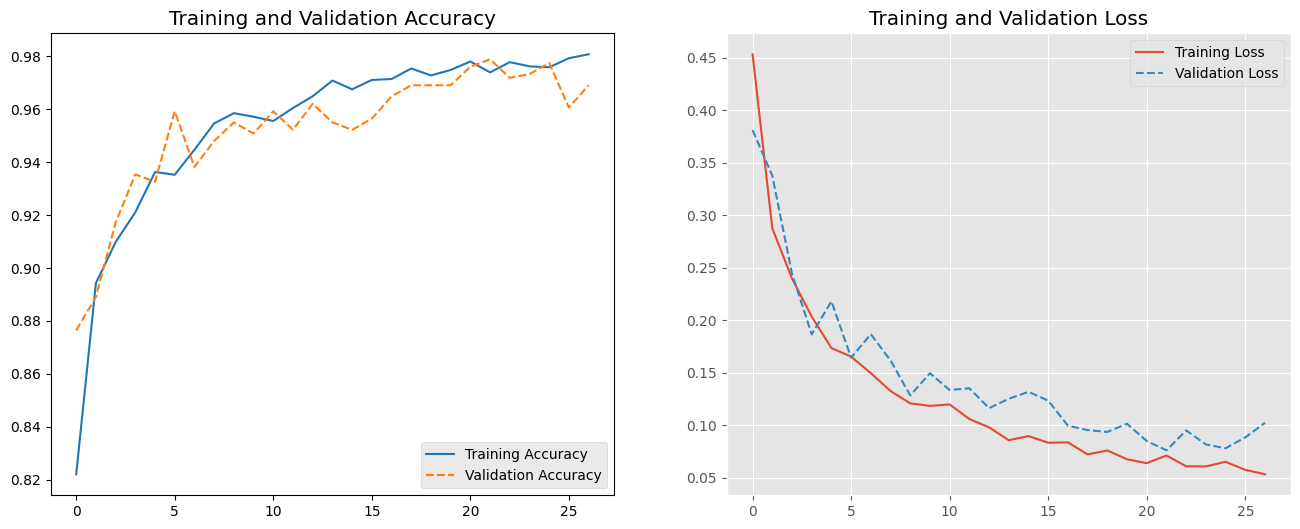

In [ ]:
plot_result(history)

In [ ]:
pred = model.evaluate(test_gen)

7/7 [==============================] - 266s 36s/step - loss: 0.1475 - accuracy: 0.9633


Evaluate model with test set:
1/1 [==============================] - 1s 1s/step
Accuracy:  0.9633375474083439
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       242
           1       0.99      0.96      0.97       549

    accuracy                           0.96       791
   macro avg       0.95      0.97      0.96       791
weighted avg       0.97      0.96      0.96       791



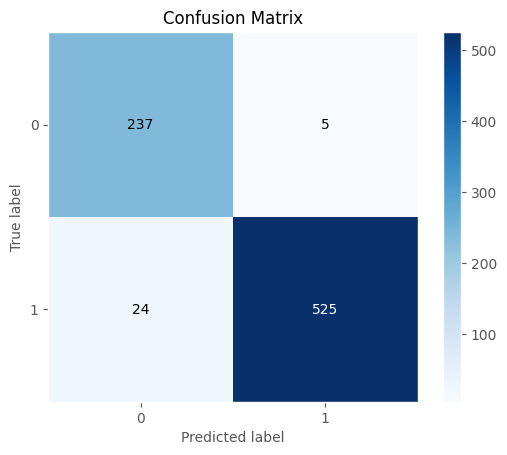

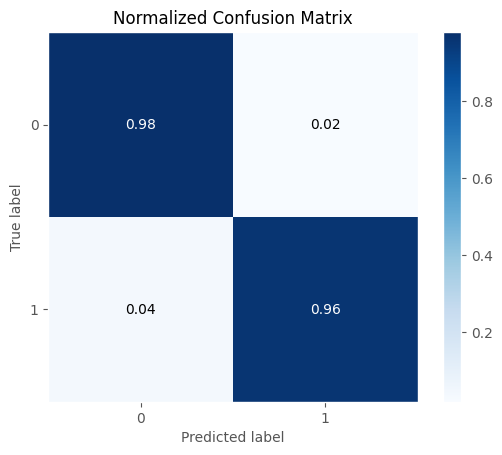

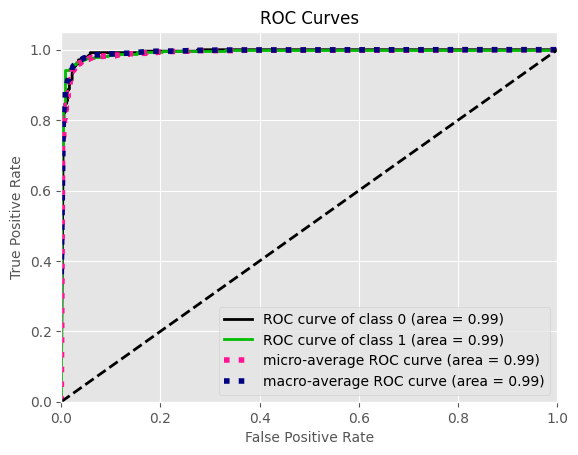

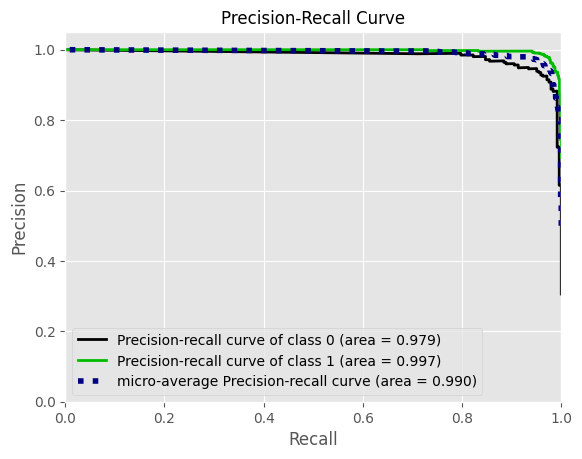

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

### MSB

#### 40x

In [ ]:
train_generation = dataset("./msb/40/training_image/",train = True)
val_generation = dataset("./msb/40/validating_image/",train = False)
test_gen = dataset("./msb/40/testing_image/",train = False)

Found 2158 files belonging to 2 classes.
Found 192 files belonging to 2 classes.
Found 204 files belonging to 2 classes.


In [ ]:
#build the model
model = resnet_builder()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 preprocess (Lambda)            (None, 224, 224, 3)  0           ['input_10[0][0]']               
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['preprocess[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 3, 3, 2048)  0           ['resnet50[0][0]']         

In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Train model for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 0.6131 - accuracy: 0.7655 

17/17 [==============================] - 597s 20s/step - loss: 0.6131 - accuracy: 0.7655 - val_loss: 0.3829 - val_accuracy: 0.8438
Epoch 2/50
17/17 [==============================] - 68s 3s/step - loss: 0.3655 - accuracy: 0.8577 - val_loss: 0.6672 - val_accuracy: 0.7708
Epoch 3/50
17/17 [==============================] - 68s 3s/step - loss: 0.2567 - accuracy: 0.9096 - val_loss: 0.4093 - val_accuracy: 0.8333
Epoch 4/50
17/17 [==============================] - ETA: 0s - loss: 0.2261 - accuracy: 0.9106

17/17 [==============================] - 100s 5s/step - loss: 0.2261 - accuracy: 0.9106 - val_loss: 0.1736 - val_accuracy: 0.9323
Epoch 5/50
17/17 [==============================] - ETA: 0s - loss: 0.1986 - accuracy: 0.9263

17/17 [==============================] - 94s 5s/step - loss: 0.1986 - accuracy: 0.9263 - val_loss: 0.1532 - val_accuracy: 0.9688
Epoch 6/50
17/17 [==============================] - 68s 3s/step - loss: 0.1577 - accuracy: 0.9430 - val_loss: 0.3295 - val_accuracy: 0.8542
Epoch 7/50
17/17 [==============================] - ETA: 0s - loss: 0.1302 - accuracy: 0.9541

17/17 [==============================] - 90s 5s/step - loss: 0.1302 - accuracy: 0.9541 - val_loss: 0.1210 - val_accuracy: 0.9375
Epoch 8/50
17/17 [==============================] - ETA: 0s - loss: 0.1270 - accuracy: 0.9551

17/17 [==============================] - 94s 5s/step - loss: 0.1270 - accuracy: 0.9551 - val_loss: 0.0945 - val_accuracy: 0.9740
Epoch 9/50
17/17 [==============================] - 66s 3s/step - loss: 0.1328 - accuracy: 0.9541 - val_loss: 0.1668 - val_accuracy: 0.9323
Epoch 10/50
17/17 [==============================] - 67s 3s/step - loss: 0.1098 - accuracy: 0.9606 - val_loss: 0.1111 - val_accuracy: 0.9635
Epoch 11/50
17/17 [==============================] - 67s 3s/step - loss: 0.0951 - accuracy: 0.9643 - val_loss: 0.1008 - val_accuracy: 0.9531
Epoch 12/50
17/17 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9731

17/17 [==============================] - 91s 5s/step - loss: 0.0748 - accuracy: 0.9731 - val_loss: 0.0671 - val_accuracy: 0.9688
Epoch 13/50
17/17 [==============================] - 67s 3s/step - loss: 0.0766 - accuracy: 0.9708 - val_loss: 0.0866 - val_accuracy: 0.9531
Epoch 14/50
17/17 [==============================] - 65s 3s/step - loss: 0.0675 - accuracy: 0.9801 - val_loss: 0.0911 - val_accuracy: 0.9635
Epoch 15/50
17/17 [==============================] - 63s 3s/step - loss: 0.0695 - accuracy: 0.9782 - val_loss: 0.0892 - val_accuracy: 0.9740
Epoch 16/50
17/17 [==============================] - 65s 3s/step - loss: 0.0686 - accuracy: 0.9764 - val_loss: 0.0974 - val_accuracy: 0.9583
Epoch 17/50
17/17 [==============================] - 67s 3s/step - loss: 0.0654 - accuracy: 0.9773 - val_loss: 0.0883 - val_accuracy: 0.9531


In [ ]:
model.save('Resnet_inception_40_model.h5')

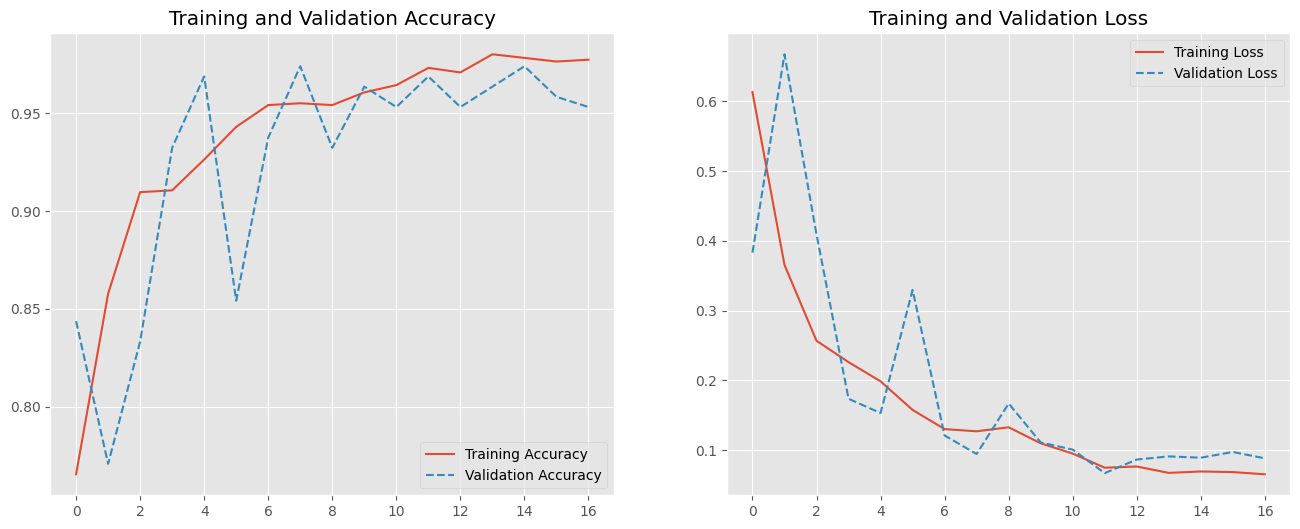

In [ ]:
plot_result(history)

In [ ]:
#model = tf.keras.models.load_model("./Resnet_inception_40_model.h5")

In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 52s 18s/step - loss: 0.1271 - accuracy: 0.9559


Evaluate model with test set:
3/3 [==============================] - 2s 499ms/step
Accuracy:  0.9558823529411765
              precision    recall  f1-score   support

           0       0.96      0.88      0.92        58
           1       0.95      0.99      0.97       146

    accuracy                           0.96       204
   macro avg       0.96      0.93      0.94       204
weighted avg       0.96      0.96      0.96       204



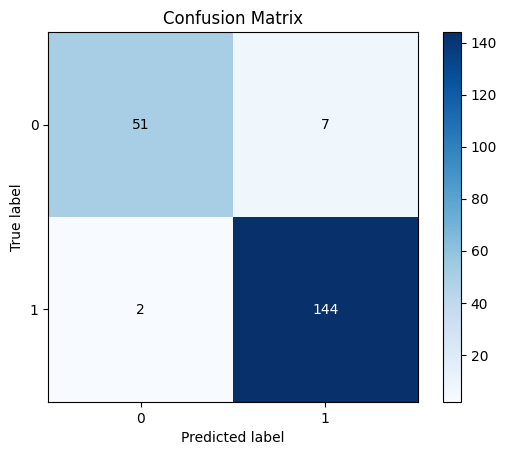

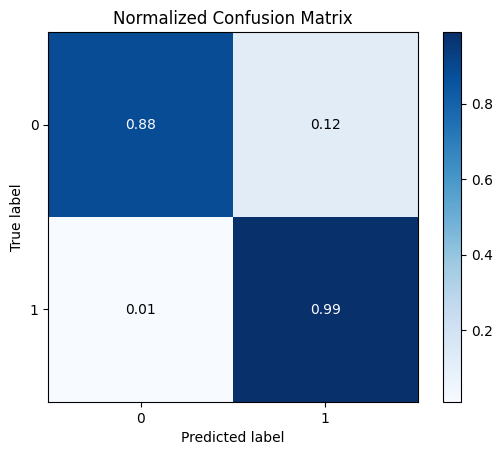

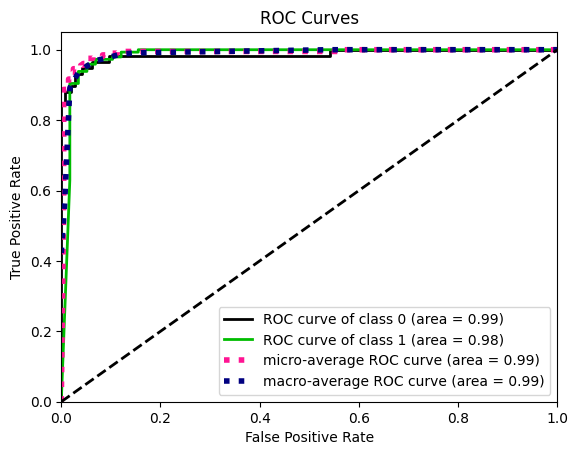

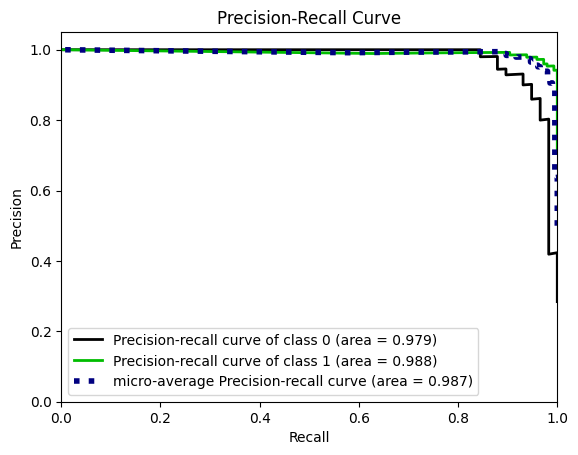

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

#### 100X

In [ ]:
train_generation = dataset("./msb/100/training_image/",train = True)
val_generation = dataset("./msb/100/validating_image/",train = False)
test_gen = dataset("./msb/100/testing_image/",train = False)

Found 2389 files belonging to 2 classes.
Found 175 files belonging to 2 classes.
Found 190 files belonging to 2 classes.


In [ ]:
#build the model
model = resnet_builder()
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 preprocess (Lambda)            (None, 224, 224, 3)  0           ['input_12[0][0]']               
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['preprocess[0][0]']             
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 3, 3, 2048)  0           ['resnet50[0][0]']         

In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Train model for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 0.6289 - accuracy: 0.7614 

19/19 [==============================] - 563s 19s/step - loss: 0.6289 - accuracy: 0.7614 - val_loss: 1.8113 - val_accuracy: 0.5600
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 0.3325 - accuracy: 0.8836

19/19 [==============================] - 128s 6s/step - loss: 0.3325 - accuracy: 0.8836 - val_loss: 0.7445 - val_accuracy: 0.8343
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 0.2597 - accuracy: 0.9058

19/19 [==============================] - 109s 5s/step - loss: 0.2597 - accuracy: 0.9058 - val_loss: 0.5415 - val_accuracy: 0.8571
Epoch 4/50
19/19 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.9201

19/19 [==============================] - 108s 5s/step - loss: 0.2219 - accuracy: 0.9201 - val_loss: 0.3897 - val_accuracy: 0.8857
Epoch 5/50
19/19 [==============================] - 82s 3s/step - loss: 0.1870 - accuracy: 0.9318 - val_loss: 0.5103 - val_accuracy: 0.8343
Epoch 6/50
19/19 [==============================] - ETA: 0s - loss: 0.1575 - accuracy: 0.9481

19/19 [==============================] - 112s 5s/step - loss: 0.1575 - accuracy: 0.9481 - val_loss: 0.3620 - val_accuracy: 0.8800
Epoch 7/50
19/19 [==============================] - ETA: 0s - loss: 0.1811 - accuracy: 0.9360

19/19 [==============================] - 110s 5s/step - loss: 0.1811 - accuracy: 0.9360 - val_loss: 0.1742 - val_accuracy: 0.9543
Epoch 8/50
19/19 [==============================] - 81s 3s/step - loss: 0.1735 - accuracy: 0.9406 - val_loss: 0.2436 - val_accuracy: 0.9143
Epoch 9/50
19/19 [==============================] - 81s 3s/step - loss: 0.1441 - accuracy: 0.9473 - val_loss: 0.2018 - val_accuracy: 0.9486
Epoch 10/50
19/19 [==============================] - 78s 3s/step - loss: 0.1409 - accuracy: 0.9481 - val_loss: 0.1813 - val_accuracy: 0.9314
Epoch 11/50
19/19 [==============================] - 81s 3s/step - loss: 0.1088 - accuracy: 0.9615 - val_loss: 0.3022 - val_accuracy: 0.8857
Epoch 12/50
19/19 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.9569

19/19 [==============================] - 109s 5s/step - loss: 0.1156 - accuracy: 0.9569 - val_loss: 0.1158 - val_accuracy: 0.9543
Epoch 13/50
19/19 [==============================] - 78s 3s/step - loss: 0.0952 - accuracy: 0.9665 - val_loss: 0.2463 - val_accuracy: 0.9143
Epoch 14/50
19/19 [==============================] - 78s 3s/step - loss: 0.1002 - accuracy: 0.9661 - val_loss: 0.1342 - val_accuracy: 0.9371
Epoch 15/50
19/19 [==============================] - 80s 3s/step - loss: 0.1078 - accuracy: 0.9661 - val_loss: 0.1189 - val_accuracy: 0.9600
Epoch 16/50
19/19 [==============================] - 84s 4s/step - loss: 0.0861 - accuracy: 0.9661 - val_loss: 0.3260 - val_accuracy: 0.8743
Epoch 17/50
19/19 [==============================] - 79s 3s/step - loss: 0.0934 - accuracy: 0.9690 - val_loss: 0.1411 - val_accuracy: 0.9543


In [ ]:
model.save('Resnet_inception_100_model.h5')

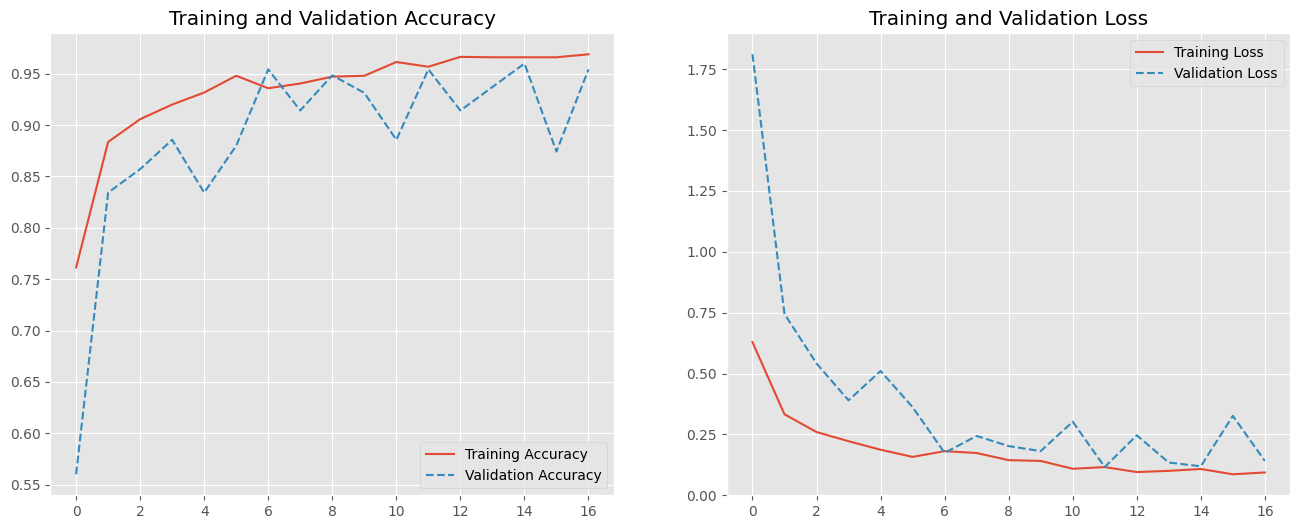

In [ ]:
plot_result(history)

In [ ]:
#model = tf.keras.models.load_model("./Resnet_inception_100_model.h5")

In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 49s 15s/step - loss: 0.1165 - accuracy: 0.9737


Evaluate model with test set:
2/2 [==============================] - 4s 1s/step
Accuracy:  0.9736842105263158
              precision    recall  f1-score   support

           0       0.93      0.98      0.96        55
           1       0.99      0.97      0.98       135

    accuracy                           0.97       190
   macro avg       0.96      0.98      0.97       190
weighted avg       0.97      0.97      0.97       190



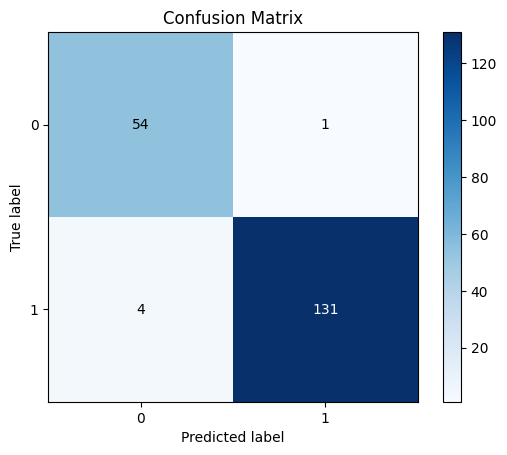

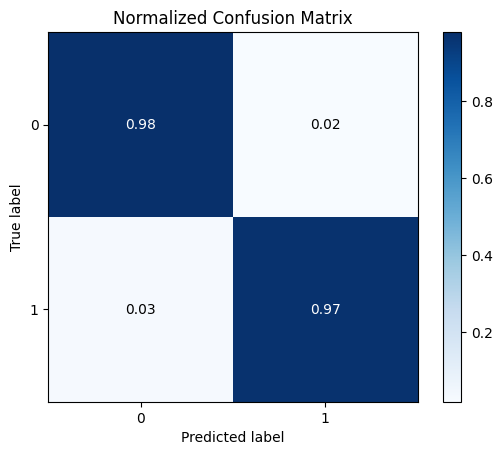

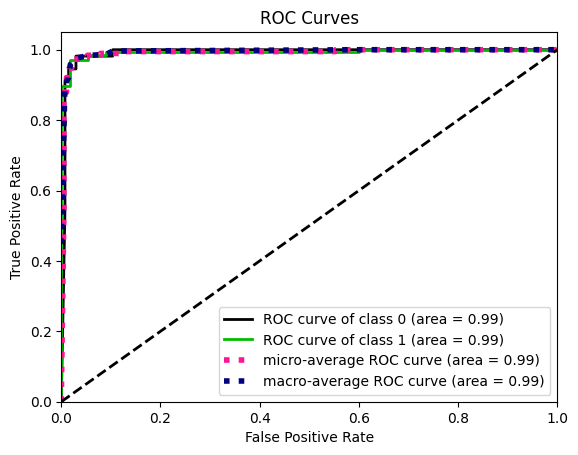

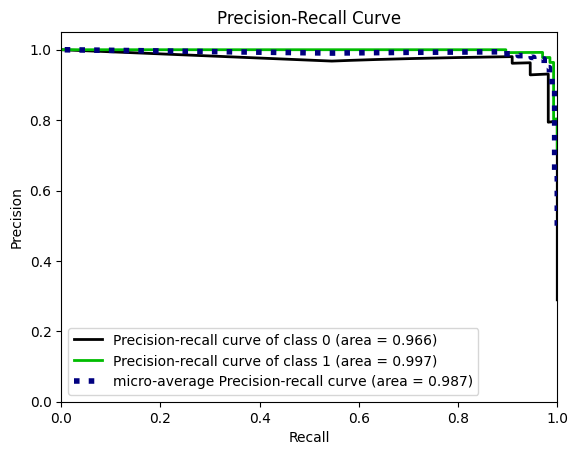

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

#### 200X

In [ ]:
train_generation = dataset("./msb/200/training_image/",train = True)
val_generation = dataset("./msb/200/validating_image/",train = False)
test_gen = dataset("./msb/200/testing_image/",train = False)

Found 2215 files belonging to 2 classes.
Found 191 files belonging to 2 classes.
Found 211 files belonging to 2 classes.


In [ ]:
#build the model
model = resnet_builder()
model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 preprocess (Lambda)            (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['preprocess[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2

In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Train model for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 0.5073 - accuracy: 0.8005 

18/18 [==============================] - 682s 21s/step - loss: 0.5073 - accuracy: 0.8005 - val_loss: 0.3902 - val_accuracy: 0.8796
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.2931 - accuracy: 0.8989

18/18 [==============================] - 95s 4s/step - loss: 0.2931 - accuracy: 0.8989 - val_loss: 0.3386 - val_accuracy: 0.9162
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.2404 - accuracy: 0.9151

18/18 [==============================] - 97s 5s/step - loss: 0.2404 - accuracy: 0.9151 - val_loss: 0.2816 - val_accuracy: 0.9215
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 0.2027 - accuracy: 0.9273

18/18 [==============================] - 92s 4s/step - loss: 0.2027 - accuracy: 0.9273 - val_loss: 0.2618 - val_accuracy: 0.9424
Epoch 5/50
18/18 [==============================] - ETA: 0s - loss: 0.1973 - accuracy: 0.9287

18/18 [==============================] - 89s 4s/step - loss: 0.1973 - accuracy: 0.9287 - val_loss: 0.2437 - val_accuracy: 0.9162
Epoch 6/50
18/18 [==============================] - 65s 3s/step - loss: 0.1435 - accuracy: 0.9449 - val_loss: 0.2833 - val_accuracy: 0.9162
Epoch 7/50
18/18 [==============================] - ETA: 0s - loss: 0.1463 - accuracy: 0.9427

18/18 [==============================] - 90s 4s/step - loss: 0.1463 - accuracy: 0.9427 - val_loss: 0.2387 - val_accuracy: 0.9319
Epoch 8/50
18/18 [==============================] - ETA: 0s - loss: 0.1475 - accuracy: 0.9494

18/18 [==============================] - 93s 5s/step - loss: 0.1475 - accuracy: 0.9494 - val_loss: 0.1830 - val_accuracy: 0.9372
Epoch 9/50
18/18 [==============================] - 67s 3s/step - loss: 0.1228 - accuracy: 0.9576 - val_loss: 0.2163 - val_accuracy: 0.9215
Epoch 10/50
18/18 [==============================] - ETA: 0s - loss: 0.1262 - accuracy: 0.9517

18/18 [==============================] - 88s 4s/step - loss: 0.1262 - accuracy: 0.9517 - val_loss: 0.1559 - val_accuracy: 0.9476
Epoch 11/50
18/18 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9607

18/18 [==============================] - 89s 4s/step - loss: 0.1186 - accuracy: 0.9607 - val_loss: 0.1364 - val_accuracy: 0.9529
Epoch 12/50
18/18 [==============================] - 61s 3s/step - loss: 0.1037 - accuracy: 0.9648 - val_loss: 0.1458 - val_accuracy: 0.9372
Epoch 13/50
18/18 [==============================] - 64s 3s/step - loss: 0.0846 - accuracy: 0.9707 - val_loss: 0.3036 - val_accuracy: 0.9162
Epoch 14/50
18/18 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9661

18/18 [==============================] - 87s 4s/step - loss: 0.0880 - accuracy: 0.9661 - val_loss: 0.1225 - val_accuracy: 0.9634
Epoch 15/50
18/18 [==============================] - 62s 3s/step - loss: 0.0893 - accuracy: 0.9652 - val_loss: 0.1597 - val_accuracy: 0.9476
Epoch 16/50
18/18 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9670

18/18 [==============================] - 86s 4s/step - loss: 0.0916 - accuracy: 0.9670 - val_loss: 0.1076 - val_accuracy: 0.9529
Epoch 17/50
18/18 [==============================] - 65s 3s/step - loss: 0.0742 - accuracy: 0.9774 - val_loss: 0.1239 - val_accuracy: 0.9529
Epoch 18/50
18/18 [==============================] - ETA: 0s - loss: 0.0672 - accuracy: 0.9747

18/18 [==============================] - 88s 4s/step - loss: 0.0672 - accuracy: 0.9747 - val_loss: 0.1054 - val_accuracy: 0.9581
Epoch 19/50
18/18 [==============================] - 61s 3s/step - loss: 0.0722 - accuracy: 0.9756 - val_loss: 0.1576 - val_accuracy: 0.9424
Epoch 20/50
18/18 [==============================] - ETA: 0s - loss: 0.0696 - accuracy: 0.9716

18/18 [==============================] - 88s 4s/step - loss: 0.0696 - accuracy: 0.9716 - val_loss: 0.1006 - val_accuracy: 0.9686
Epoch 21/50
18/18 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9711

18/18 [==============================] - 87s 4s/step - loss: 0.0723 - accuracy: 0.9711 - val_loss: 0.0558 - val_accuracy: 0.9738
Epoch 22/50
18/18 [==============================] - ETA: 0s - loss: 0.0594 - accuracy: 0.9779

18/18 [==============================] - 89s 4s/step - loss: 0.0594 - accuracy: 0.9779 - val_loss: 0.0557 - val_accuracy: 0.9843
Epoch 23/50
18/18 [==============================] - 60s 3s/step - loss: 0.0543 - accuracy: 0.9828 - val_loss: 0.0637 - val_accuracy: 0.9791
Epoch 24/50
18/18 [==============================] - 63s 3s/step - loss: 0.0549 - accuracy: 0.9815 - val_loss: 0.0822 - val_accuracy: 0.9738
Epoch 25/50
18/18 [==============================] - 61s 3s/step - loss: 0.0651 - accuracy: 0.9792 - val_loss: 0.0650 - val_accuracy: 0.9791
Epoch 26/50
18/18 [==============================] - 60s 3s/step - loss: 0.0599 - accuracy: 0.9779 - val_loss: 0.1931 - val_accuracy: 0.9267
Epoch 27/50
18/18 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9792

18/18 [==============================] - 87s 4s/step - loss: 0.0608 - accuracy: 0.9792 - val_loss: 0.0467 - val_accuracy: 0.9738
Epoch 28/50
18/18 [==============================] - 60s 3s/step - loss: 0.0449 - accuracy: 0.9856 - val_loss: 0.0835 - val_accuracy: 0.9791
Epoch 29/50
18/18 [==============================] - 60s 3s/step - loss: 0.0449 - accuracy: 0.9865 - val_loss: 0.1932 - val_accuracy: 0.9267
Epoch 30/50
18/18 [==============================] - 63s 3s/step - loss: 0.0511 - accuracy: 0.9837 - val_loss: 0.0630 - val_accuracy: 0.9843
Epoch 31/50
18/18 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.9878

18/18 [==============================] - 88s 4s/step - loss: 0.0425 - accuracy: 0.9878 - val_loss: 0.0460 - val_accuracy: 0.9738
Epoch 32/50
18/18 [==============================] - 60s 3s/step - loss: 0.0520 - accuracy: 0.9833 - val_loss: 0.0635 - val_accuracy: 0.9791
Epoch 33/50
18/18 [==============================] - ETA: 0s - loss: 0.0384 - accuracy: 0.9847

18/18 [==============================] - 88s 4s/step - loss: 0.0384 - accuracy: 0.9847 - val_loss: 0.0459 - val_accuracy: 0.9895
Epoch 34/50
18/18 [==============================] - 63s 3s/step - loss: 0.0311 - accuracy: 0.9896 - val_loss: 0.1204 - val_accuracy: 0.9581
Epoch 35/50
18/18 [==============================] - 62s 3s/step - loss: 0.0447 - accuracy: 0.9860 - val_loss: 0.0759 - val_accuracy: 0.9738
Epoch 36/50
18/18 [==============================] - 60s 2s/step - loss: 0.0316 - accuracy: 0.9905 - val_loss: 0.1071 - val_accuracy: 0.9686
Epoch 37/50
18/18 [==============================] - 66s 3s/step - loss: 0.0382 - accuracy: 0.9860 - val_loss: 0.0747 - val_accuracy: 0.9686
Epoch 38/50
18/18 [==============================] - 63s 3s/step - loss: 0.0361 - accuracy: 0.9865 - val_loss: 0.0750 - val_accuracy: 0.9791


In [ ]:
model.save('Resnet_inception_200_model.h5')

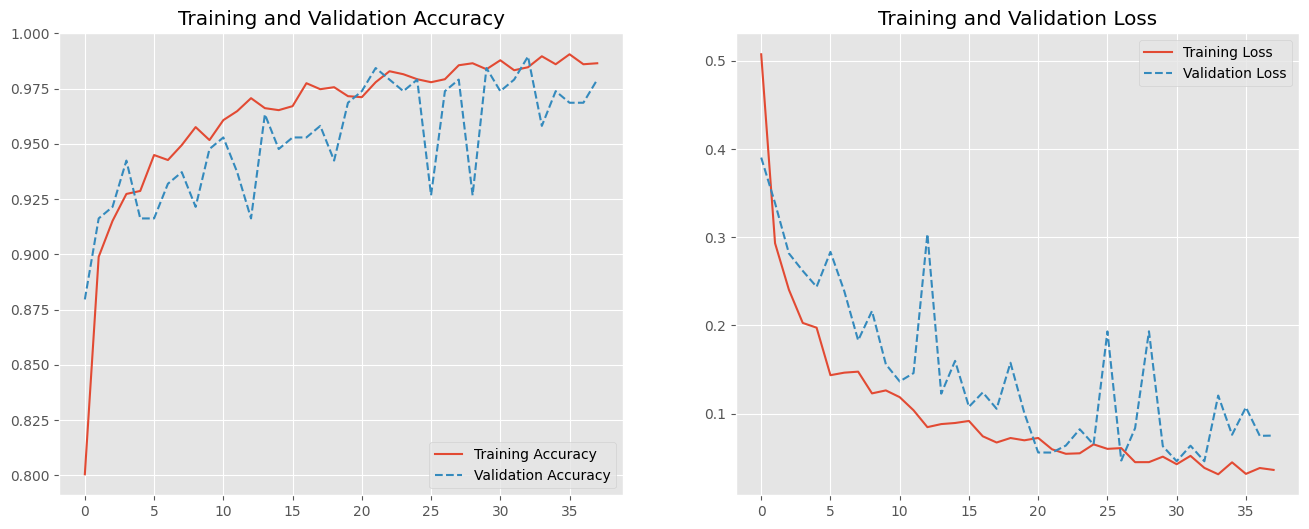

In [ ]:
plot_result(history)

In [ ]:
#model = tf.keras.models.load_model("./Resnet_inception_200_model.h5")

In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 87s 34s/step - loss: 0.1543 - accuracy: 0.9668


Evaluate model with test set:
3/3 [==============================] - 2s 581ms/step
Accuracy:  0.966824644549763
              precision    recall  f1-score   support

           0       0.94      0.95      0.95        64
           1       0.98      0.97      0.98       147

    accuracy                           0.97       211
   macro avg       0.96      0.96      0.96       211
weighted avg       0.97      0.97      0.97       211



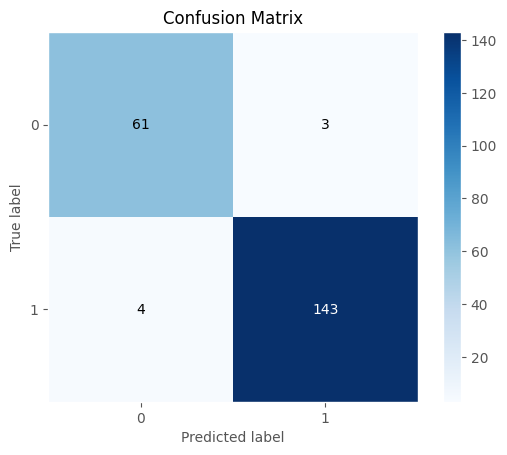

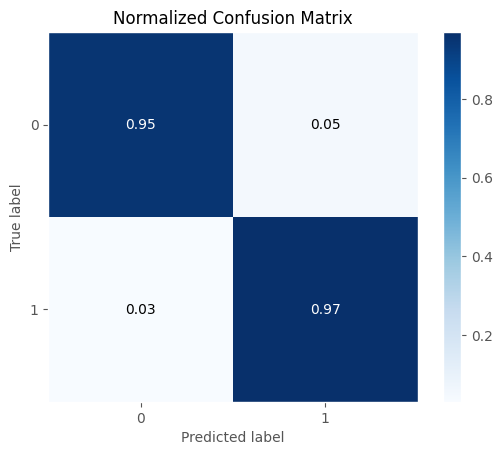

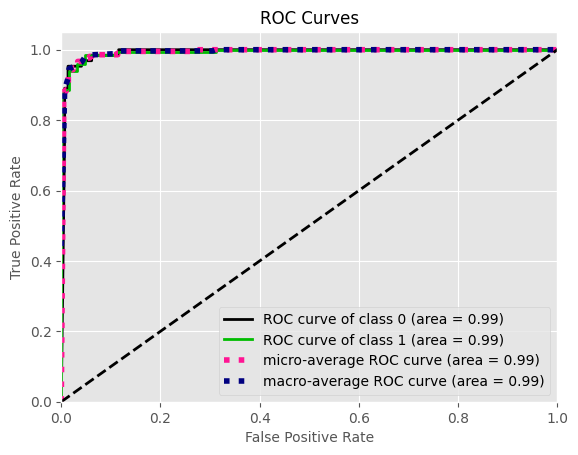

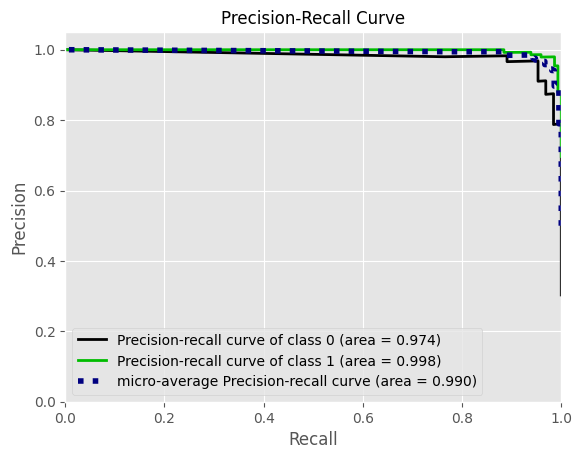

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

#### 400X

In [ ]:
train_generation = dataset("./msb/400/training_image/",train = True)
val_generation = dataset("./msb/400/validating_image/",train = False)
test_gen = dataset("./msb/400/testing_image/",train = False)

Found 1996 files belonging to 2 classes.
Found 154 files belonging to 2 classes.
Found 186 files belonging to 2 classes.


In [ ]:
#build the model
model = resnet_builder()
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 preprocess (Lambda)            (None, 224, 224, 3)  0           ['input_16[0][0]']               
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['preprocess[0][0]']             
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 3, 3, 2048)  0           ['resnet50[0][0]']        

In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Train model for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 0.5837 - accuracy: 0.7836 

16/16 [==============================] - 430s 15s/step - loss: 0.5837 - accuracy: 0.7836 - val_loss: 0.7208 - val_accuracy: 0.8377
Epoch 2/50
16/16 [==============================] - 70s 3s/step - loss: 0.3740 - accuracy: 0.8702 - val_loss: 0.9182 - val_accuracy: 0.7532
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 0.3009 - accuracy: 0.8983

16/16 [==============================] - 93s 5s/step - loss: 0.3009 - accuracy: 0.8983 - val_loss: 0.5831 - val_accuracy: 0.8377
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 0.2675 - accuracy: 0.9068

16/16 [==============================] - 98s 5s/step - loss: 0.2675 - accuracy: 0.9068 - val_loss: 0.4544 - val_accuracy: 0.8766
Epoch 5/50
16/16 [==============================] - ETA: 0s - loss: 0.2475 - accuracy: 0.9093

16/16 [==============================] - 93s 5s/step - loss: 0.2475 - accuracy: 0.9093 - val_loss: 0.3125 - val_accuracy: 0.9091
Epoch 6/50
16/16 [==============================] - 68s 3s/step - loss: 0.2342 - accuracy: 0.9133 - val_loss: 0.3175 - val_accuracy: 0.9091
Epoch 7/50
16/16 [==============================] - 65s 3s/step - loss: 0.1982 - accuracy: 0.9264 - val_loss: 0.3572 - val_accuracy: 0.8636
Epoch 8/50
16/16 [==============================] - ETA: 0s - loss: 0.1920 - accuracy: 0.9279

16/16 [==============================] - 99s 5s/step - loss: 0.1920 - accuracy: 0.9279 - val_loss: 0.2935 - val_accuracy: 0.8961
Epoch 9/50
16/16 [==============================] - 65s 3s/step - loss: 0.1445 - accuracy: 0.9474 - val_loss: 0.3285 - val_accuracy: 0.8896
Epoch 10/50
16/16 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.9489

16/16 [==============================] - 96s 5s/step - loss: 0.1494 - accuracy: 0.9489 - val_loss: 0.2231 - val_accuracy: 0.9481
Epoch 11/50
16/16 [==============================] - 64s 3s/step - loss: 0.1573 - accuracy: 0.9459 - val_loss: 0.2463 - val_accuracy: 0.9351
Epoch 12/50
16/16 [==============================] - 68s 3s/step - loss: 0.1551 - accuracy: 0.9429 - val_loss: 0.2251 - val_accuracy: 0.9156
Epoch 13/50
16/16 [==============================] - 64s 3s/step - loss: 0.1332 - accuracy: 0.9499 - val_loss: 0.5786 - val_accuracy: 0.8182
Epoch 14/50
16/16 [==============================] - 65s 3s/step - loss: 0.1215 - accuracy: 0.9534 - val_loss: 0.3084 - val_accuracy: 0.9091
Epoch 15/50
16/16 [==============================] - 65s 3s/step - loss: 0.1382 - accuracy: 0.9429 - val_loss: 0.2907 - val_accuracy: 0.9416


In [ ]:
model.save('Resnet_inception_400_model.h5')

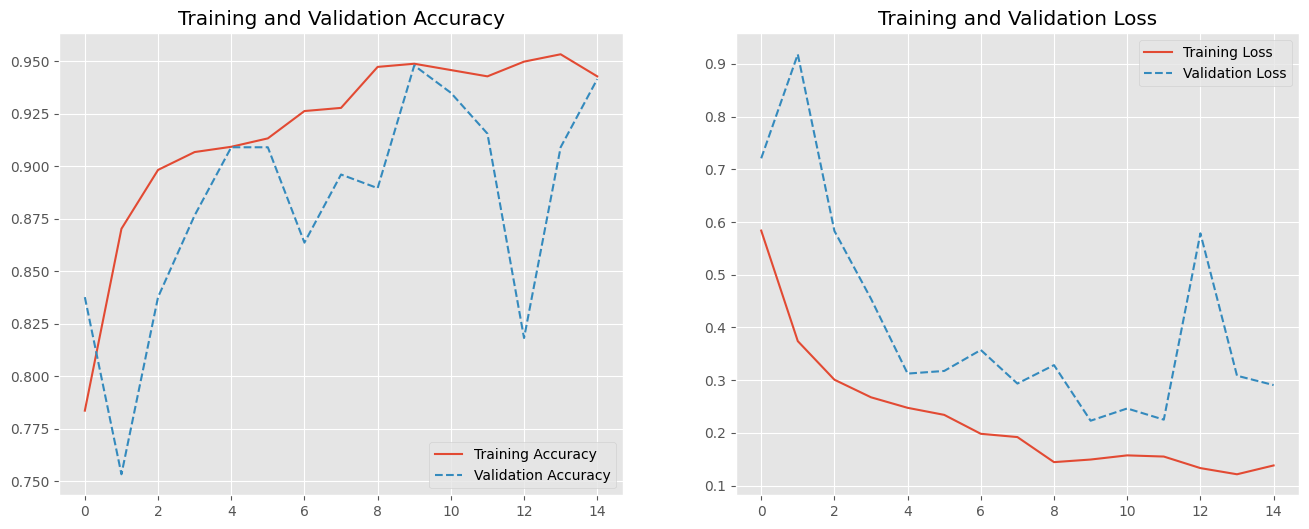

In [ ]:
plot_result(history)

In [ ]:
model = tf.keras.models.load_model("./Resnet_inception_400_model.h5")

In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 47s 13s/step - loss: 0.2208 - accuracy: 0.9301


Evaluate model with test set:


2/2 [==============================] - 2s 1s/step
Accuracy:  0.9301075268817204
              precision    recall  f1-score   support

           0       0.95      0.85      0.89        65
           1       0.92      0.98      0.95       121

    accuracy                           0.93       186
   macro avg       0.94      0.91      0.92       186
weighted avg       0.93      0.93      0.93       186



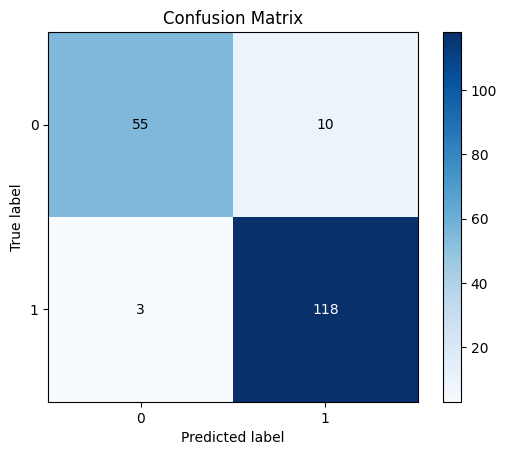

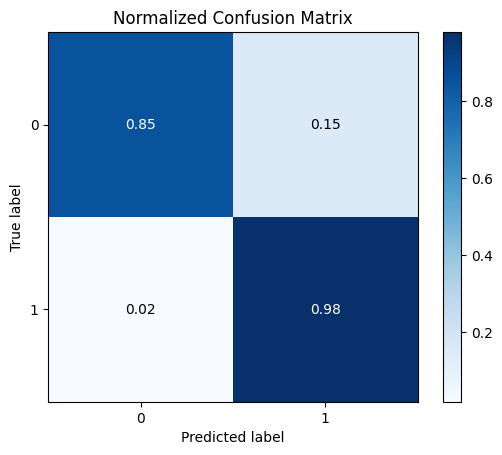

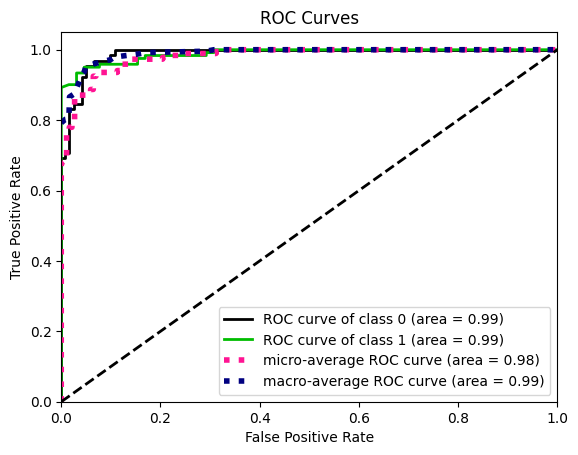

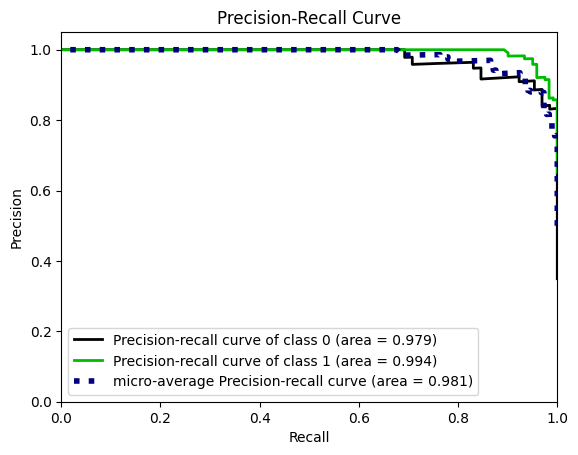

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

##MIM

In [ ]:
train_generation = dataset("./subclass/training_image/",train = True)
val_generation = dataset("./subclass/validating_image/",train = False)
test_gen = dataset("./subclass/testing_image/",train = False)

Found 8758 files belonging to 8 classes.
Found 712 files belonging to 8 classes.
Found 791 files belonging to 8 classes.


In [ ]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=1000,
  decay_rate=1,
  staircase=False)

In [ ]:
def resnet_Mbuilder():
    base_model = ResNet50(include_top=False, input_shape=(224, 224, 3))

    for i in base_model.layers:
      i.trainable = False

    preprocess_layer = Lambda(preprocess_input, name = 'preprocess')
    image = Input((224, 224, 3))
    preprocess_tensor = preprocess_layer(image)

    pre_out = base_model(preprocess_tensor)
    pre_model = Model(inputs = image , outputs = pre_out)

    def dimension_reductions_inception_module(input_layer):
        # 1x1 conv
        conv1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_layer)
        # 1x1 & 3x3 conv
        conv1_3 = Conv2D(64, (1,1), padding='same', activation='relu')(input_layer)
        conv3_3 = Conv2D(128, (3,3), padding='same', activation='relu')(conv1_3)
        # 1x1 & 5x5 conv
        conv1_5 = Conv2D(64, (1,1), padding='same', activation='relu')(input_layer)
        conv5_5 = Conv2D(32, (5,5), padding='same', activation='relu')(conv1_5)
        # 3x3 max pooling & 1x1
        pool_1 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_layer)
        conv1_p = Conv2D(64, (1,1), padding='same', activation='relu')(pool_1)
        # concatenate filters
        output_layer = Concatenate()([conv1, conv3_3, conv5_5, conv1_p])

        return output_layer

    pool_pre_model = MaxPooling2D((3,3), padding='same')(pre_model.output)
    fin_out = dimension_reductions_inception_module(pool_pre_model)
    b_norm = BatchNormalization()(fin_out)
    flat = Flatten()(b_norm)
    drop = Dropout(0.4)(flat)
    dense = Dense(8, activation='softmax')(drop)

    final_model = Model(inputs = pre_model.input, outputs = dense)

    return final_model

In [ ]:
#Defining the base model
model = resnet_Mbuilder()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 preprocess (Lambda)            (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['preprocess[0][0]']             
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 3, 3, 2048)  0           ['resnet50[0][0]']         

In [ ]:
#Compiling the model
model.compile(loss='CategoricalCrossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Model is fitted using train and validation generator for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
69/69 [==============================] - ETA: 0s - loss: 1.6645 - accuracy: 0.4789

69/69 [==============================] - 337s 4s/step - loss: 1.6645 - accuracy: 0.4789 - val_loss: 1.6953 - val_accuracy: 0.5351
Epoch 2/50
69/69 [==============================] - ETA: 0s - loss: 1.1306 - accuracy: 0.6145

69/69 [==============================] - 86s 1s/step - loss: 1.1306 - accuracy: 0.6145 - val_loss: 1.3118 - val_accuracy: 0.5758
Epoch 3/50
69/69 [==============================] - ETA: 0s - loss: 0.9680 - accuracy: 0.6613

69/69 [==============================] - 85s 1s/step - loss: 0.9680 - accuracy: 0.6613 - val_loss: 1.0949 - val_accuracy: 0.6390
Epoch 4/50
69/69 [==============================] - ETA: 0s - loss: 0.8536 - accuracy: 0.7031

69/69 [==============================] - 85s 1s/step - loss: 0.8536 - accuracy: 0.7031 - val_loss: 0.9634 - val_accuracy: 0.6643
Epoch 5/50
69/69 [==============================] - ETA: 0s - loss: 0.7623 - accuracy: 0.7333

69/69 [==============================] - 86s 1s/step - loss: 0.7623 - accuracy: 0.7333 - val_loss: 0.9155 - val_accuracy: 0.7051
Epoch 6/50
69/69 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.7525

69/69 [==============================] - 85s 1s/step - loss: 0.6950 - accuracy: 0.7525 - val_loss: 0.7548 - val_accuracy: 0.7247
Epoch 7/50
69/69 [==============================] - 60s 778ms/step - loss: 0.6500 - accuracy: 0.7702 - val_loss: 0.7842 - val_accuracy: 0.7331
Epoch 8/50
69/69 [==============================] - ETA: 0s - loss: 0.5969 - accuracy: 0.7839

69/69 [==============================] - 86s 1s/step - loss: 0.5969 - accuracy: 0.7839 - val_loss: 0.6522 - val_accuracy: 0.7725
Epoch 9/50
69/69 [==============================] - 60s 781ms/step - loss: 0.5337 - accuracy: 0.8046 - val_loss: 0.7548 - val_accuracy: 0.7472
Epoch 10/50
69/69 [==============================] - 61s 798ms/step - loss: 0.5029 - accuracy: 0.8172 - val_loss: 0.7203 - val_accuracy: 0.7654
Epoch 11/50
69/69 [==============================] - ETA: 0s - loss: 0.4805 - accuracy: 0.8262

69/69 [==============================] - 85s 1s/step - loss: 0.4805 - accuracy: 0.8262 - val_loss: 0.5917 - val_accuracy: 0.7795
Epoch 12/50
69/69 [==============================] - 61s 800ms/step - loss: 0.4540 - accuracy: 0.8301 - val_loss: 0.7328 - val_accuracy: 0.7739
Epoch 13/50
69/69 [==============================] - 60s 781ms/step - loss: 0.4277 - accuracy: 0.8427 - val_loss: 0.6210 - val_accuracy: 0.8076
Epoch 14/50
69/69 [==============================] - 60s 775ms/step - loss: 0.4062 - accuracy: 0.8507 - val_loss: 0.7111 - val_accuracy: 0.7809
Epoch 15/50
69/69 [==============================] - 61s 791ms/step - loss: 0.3792 - accuracy: 0.8598 - val_loss: 0.7003 - val_accuracy: 0.8034
Epoch 16/50
69/69 [==============================] - 60s 788ms/step - loss: 0.3714 - accuracy: 0.8639 - val_loss: 0.7169 - val_accuracy: 0.7935


In [ ]:
model.save('Resnet_inception_Mmodel.h5')

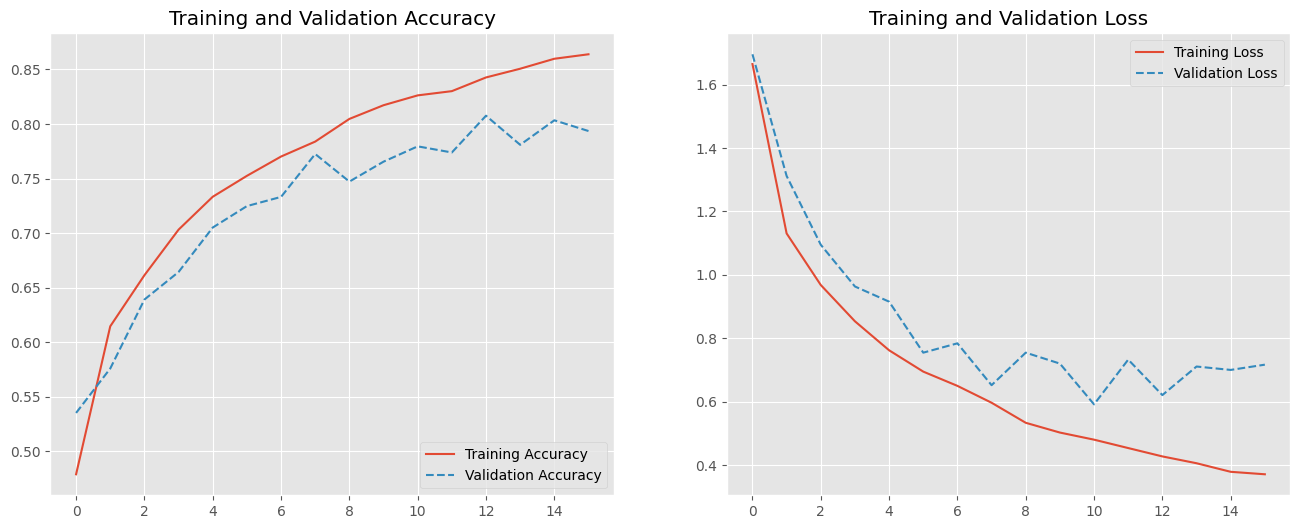

In [ ]:
plot_result(history)

In [ ]:
pred = model.evaluate(test_gen)

7/7 [==============================] - 27s 4s/step - loss: 0.5987 - accuracy: 0.8040


Evaluate model with test set:
1/1 [==============================] - 1s 1s/step
Accuracy:  0.8040455120101138
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        45
           1       0.81      0.95      0.88       339
           2       0.71      0.86      0.78        95
           3       0.88      0.32      0.47        66
           4       0.85      0.69      0.76        88
           5       0.82      0.75      0.79        56
           6       0.84      0.43      0.57        49
           7       0.79      0.91      0.84        53

    accuracy                           0.80       791
   macro avg       0.82      0.72      0.74       791
weighted avg       0.81      0.80      0.79       791



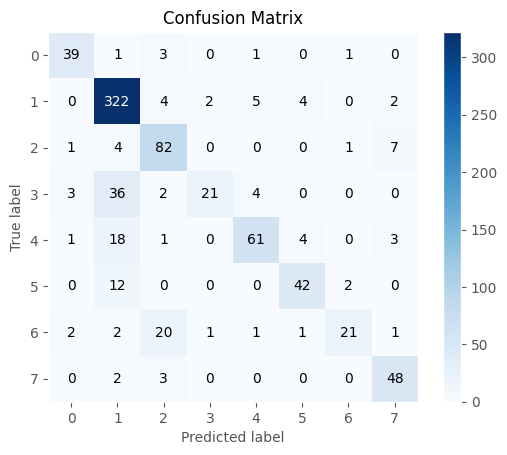

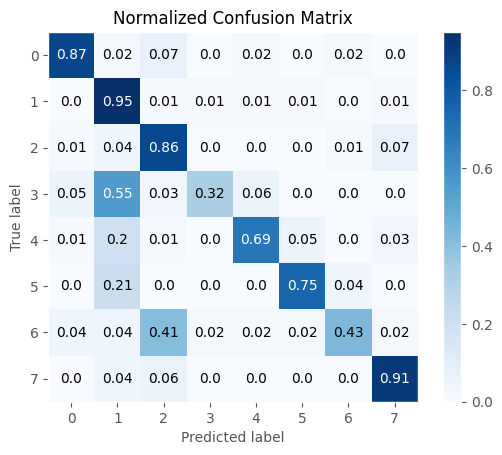

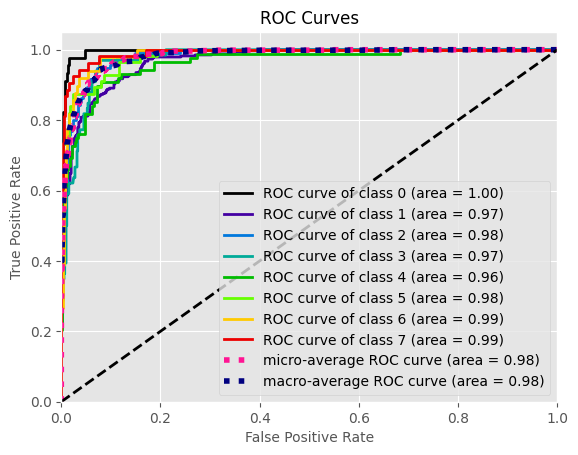

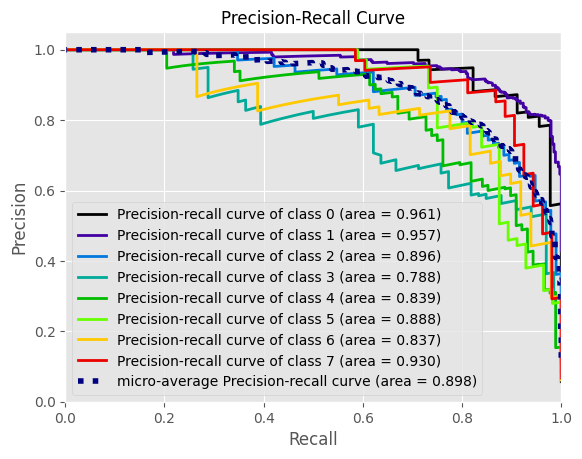

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

### MIM mag test

In [ ]:
model = tf.keras.models.load_model("./Resnet_inception_Mmodel.h5")

####40x

In [ ]:
test_gen = dataset("./mag_test/40/",train = False)

Found 204 files belonging to 8 classes.


In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 86s 19s/step - loss: 0.6825 - accuracy: 0.7892


Evaluate model with test set:
3/3 [==============================] - 2s 466ms/step
Accuracy:  0.7892156862745098
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.77      0.95      0.85        82
           2       0.66      0.86      0.75        22
           3       0.88      0.37      0.52        19
           4       0.85      0.71      0.77        24
           5       0.94      0.81      0.87        21
           6       1.00      0.31      0.48        16
           7       0.67      1.00      0.80        10

    accuracy                           0.79       204
   macro avg       0.85      0.73      0.74       204
weighted avg       0.82      0.79      0.77       204



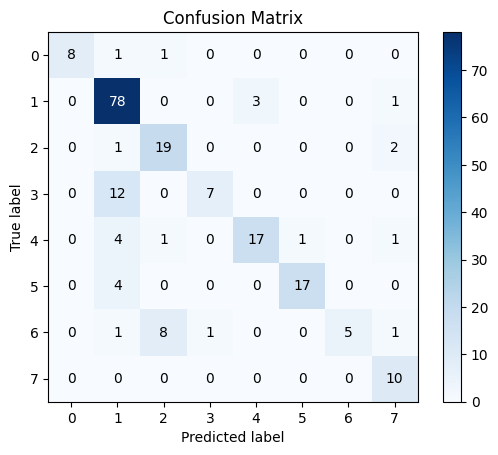

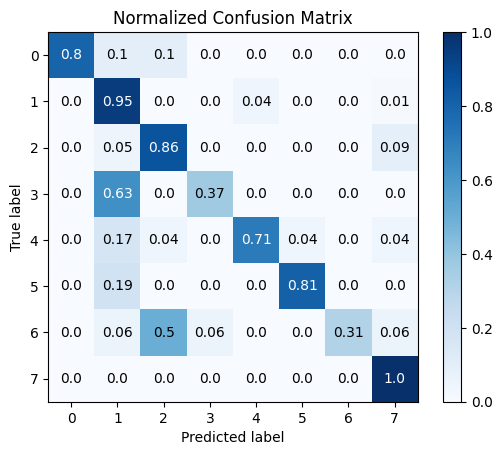

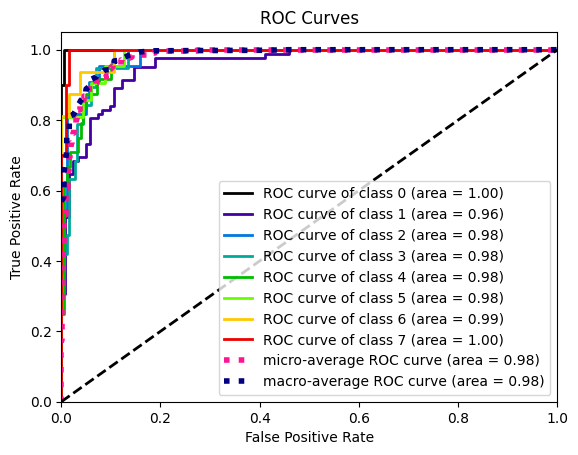

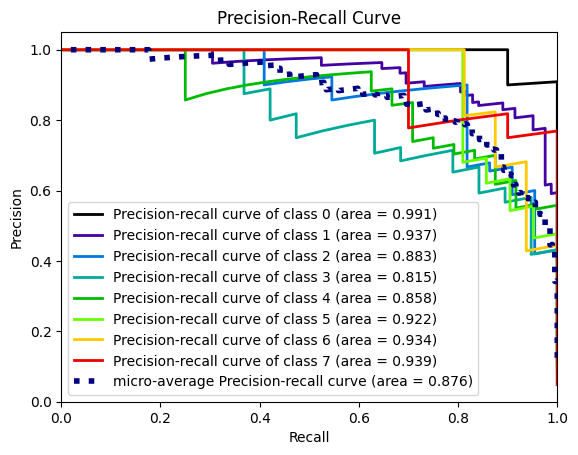

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

####100x

In [ ]:
test_gen = dataset("./mag_test/100/",train = False)

Found 190 files belonging to 8 classes.


In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 78s 26s/step - loss: 0.6204 - accuracy: 0.8158


Evaluate model with test set:
2/2 [==============================] - 1s 1s/step
Accuracy:  0.8157894736842105
              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.83      0.96      0.89        89
           2       0.73      0.88      0.80        25
           3       0.86      0.43      0.57        14
           4       0.93      0.54      0.68        24
           5       0.71      0.62      0.67         8
           6       1.00      0.50      0.67         8
           7       0.80      0.92      0.86        13

    accuracy                           0.82       190
   macro avg       0.82      0.72      0.74       190
weighted avg       0.83      0.82      0.80       190



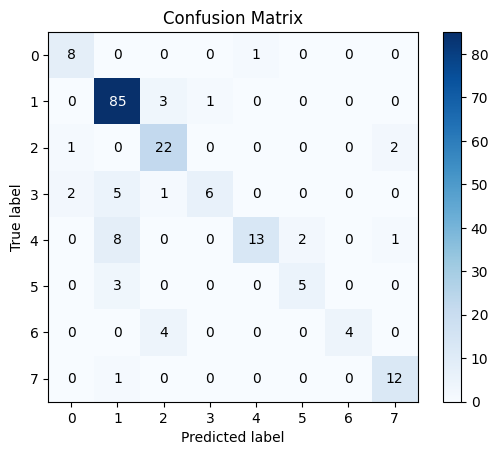

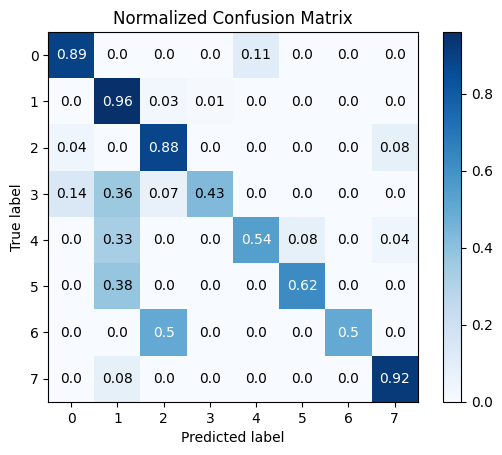

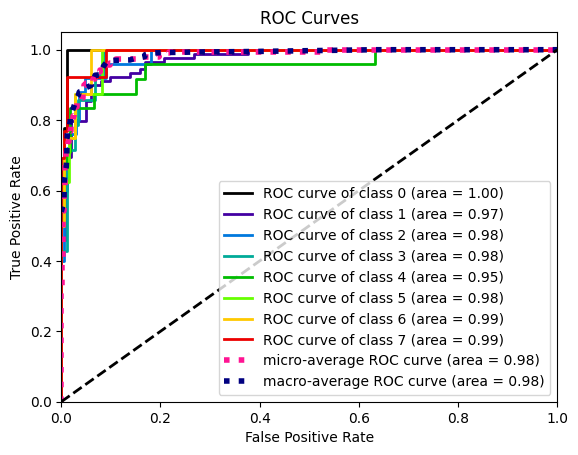

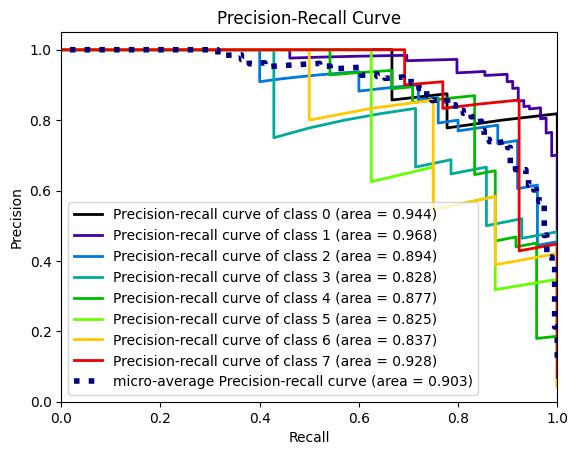

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

####200x

In [ ]:
test_gen = dataset("./mag_test/200/",train = False)

Found 211 files belonging to 8 classes.


In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 92s 35s/step - loss: 0.4571 - accuracy: 0.8389


Evaluate model with test set:
3/3 [==============================] - 1s 547ms/step
Accuracy:  0.8388625592417062
              precision    recall  f1-score   support

           0       0.76      1.00      0.87        13
           1       0.84      0.98      0.90        92
           2       0.96      0.83      0.89        29
           3       1.00      0.33      0.50        21
           4       0.81      0.81      0.81        21
           5       0.77      0.77      0.77        13
           6       0.71      0.50      0.59        10
           7       0.79      0.92      0.85        12

    accuracy                           0.84       211
   macro avg       0.83      0.77      0.77       211
weighted avg       0.85      0.84      0.82       211



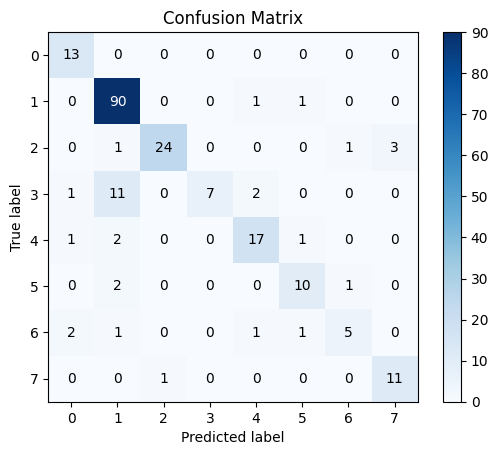

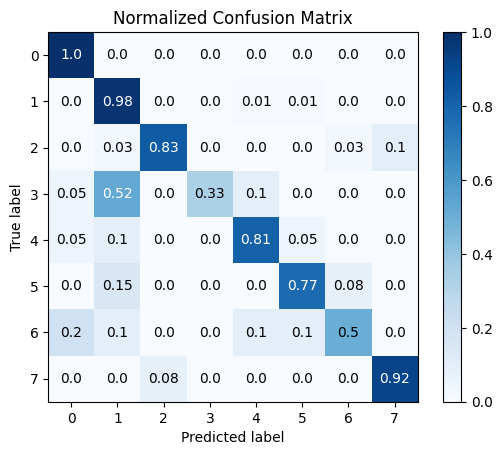

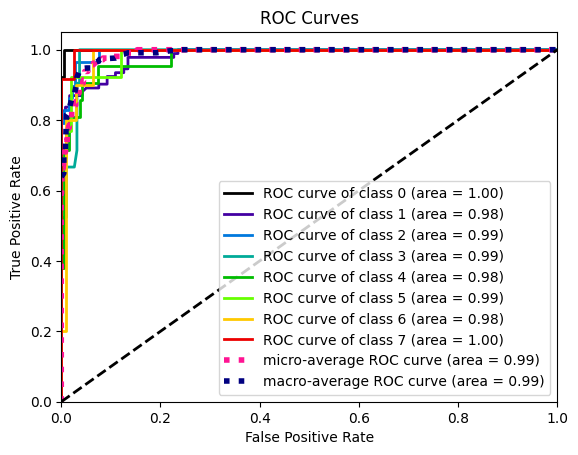

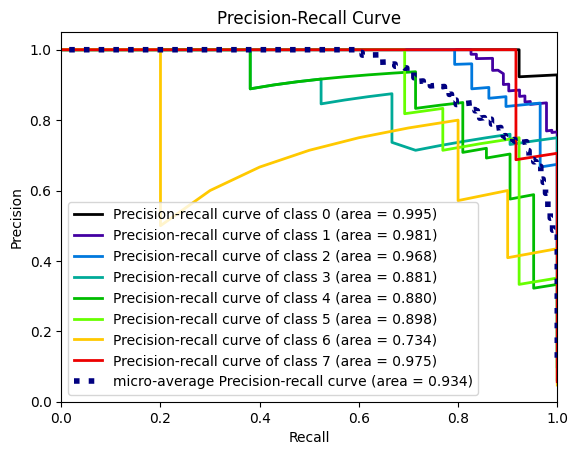

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

####400x

In [ ]:
test_gen = dataset("./mag_test/400/",train = False)

Found 186 files belonging to 8 classes.


In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 78s 24s/step - loss: 0.6450 - accuracy: 0.7688


Evaluate model with test set:
2/2 [==============================] - 1s 1s/step
Accuracy:  0.7688172043010753
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        13
           1       0.79      0.91      0.85        76
           2       0.55      0.89      0.68        19
           3       0.50      0.08      0.14        12
           4       0.82      0.74      0.78        19
           5       0.77      0.71      0.74        14
           6       0.78      0.47      0.58        15
           7       0.88      0.83      0.86        18

    accuracy                           0.77       186
   macro avg       0.76      0.68      0.69       186
weighted avg       0.77      0.77      0.75       186



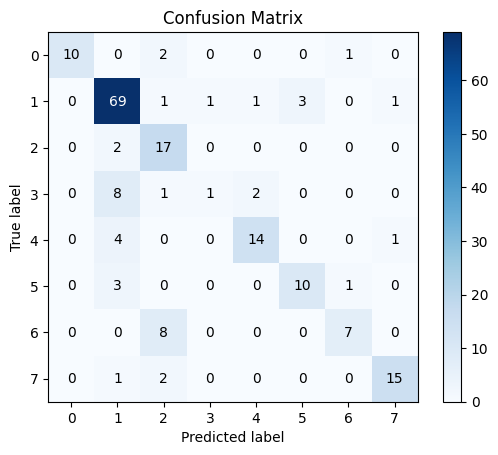

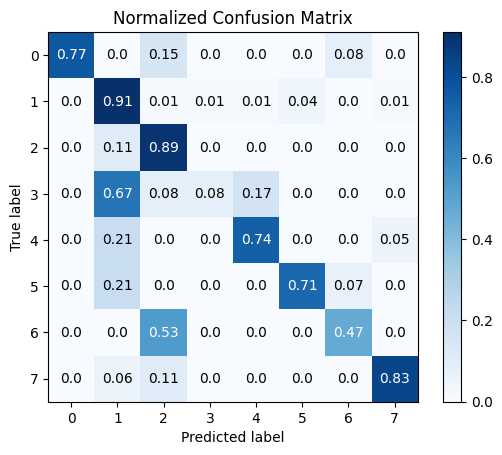

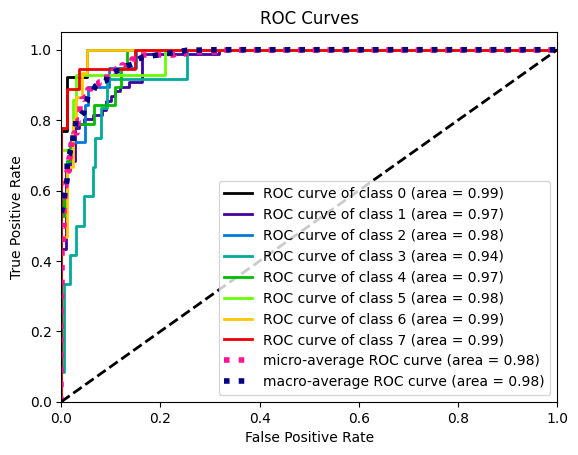

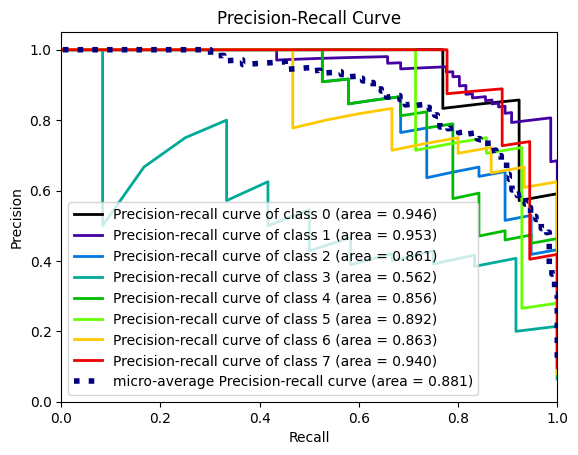

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)